In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

from fastai import *
from fastai.vision import *
from superRes.generators import *
from superRes.critics import *
from superRes.dataset import *
from superRes.loss import *
from superRes.save import *
from superRes.fid_loss import *
from superRes.ssim import *
from pathlib import Path

import torchvision
import geffnet # efficient/ mobile net

In [2]:
def get_data(bs:int, sz:int, keep_pct:float):
    return get_databunch(sz=sz, bs=bs, crappy_path=path_lowRes, 
                         good_path=path_fullRes, 
                         random_seed=None, keep_pct=keep_pct)

def get_DIV2k_data(pLow, bs:int, sz:int):
    """Given the path of low resolution images with a proper suffix
       returns a databunch
    """
    suffixes = {"dataset/DIV2K_train_LR_x8": "x8",
                "dataset/DIV2K_train_LR_difficult":"x4d", 
                "dataset/DIV2K_train_LR_mild":"x4m"}
    lowResSuffix = suffixes[str(pLow)]
    src = ImageImageList.from_folder(pLow).split_by_idxs(train_idx=list(range(0,800)), valid_idx=list(range(800,900)))
    
    data = (src.label_from_func(lambda x: path_fullRes/(x.name).replace(lowResSuffix, '')).transform(
            get_transforms(
                flip_vert=True,
                max_rotate=30,
                max_zoom=3.,
                max_lighting=.4,
                max_warp=.4,
                p_affine=.85
            ),
            size=sz,
            tfm_y=True,
        ).databunch(bs=bs, num_workers=8, no_check=True).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

def get_DIV2k_data_patches(pLow, bs:int, sz:int):
    """Given the path of low resolution images with a proper suffix
       returns a databunch
    """
    src = ImageImageList.from_folder(pLow).split_by_idxs(train_idx=list(range(0,564736)), valid_idx=list(range(564736,637408)))
    
    data = (src.label_from_func(lambda x: path_fullRes_patches/x.name).transform(
            get_transforms(
                max_zoom=3.
            ),
            size=sz,
            tfm_y=True,
        ).databunch(bs=bs, num_workers=8, no_check=True).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

def create_training_images(fn, i, p_hr, p_lr, size):
    """Create low quality images from folder p_hr in p_lr"""
    dest = p_lr/fn.relative_to(p_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [3]:
def do_fit(learn, epochs,save_name, lrs=slice(1e-3), pct_start=0.9):
    learn.fit_one_cycle(epochs, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=7)

In [4]:
path = Path('./dataset/')

path_fullRes_patches = path/"DIV2K_train_HR_Patches"/"64px"
path_lowRes_patches  = path/"DIV2K_train_LR_Patches"/"64px"

path_fullRes = path/'DIV2K_train_HR'
path_lowRes_mild = path/'DIV2K_train_LR_mild' # suffix "x4m" ~300px

proj_id = 'unet_superRes_mobilenetV3_Patches64px'

gen_name = proj_id + '_gen'
crit_name = proj_id + '_crit'

nf_factor = 2
pct_start = 1e-8

In [5]:
print(path_fullRes_patches)

dataset/DIV2K_train_HR_Patches/64px


In [6]:
# high_res = ImageList.from_folder(path_fullRes_patches, presort=True)

In [7]:
# high_res.items[564736]

In [8]:
# lr = ImageList.from_folder(path_lowRes_patches)
# hr = ImageList.from_folder(path_fullRes_patches)

# lr[10].show()
# hr[10].show()

In [9]:
model = geffnet.mobilenetv3_100
# model = models.resnet34
# model= geffnet.efficientnet_b4

In [10]:
# loss_func = FeatureLoss()
loss_func = msssim
# loss_func = calculate_frechet_distance

# 64px patch

In [11]:
bs=234
sz=64
lr = 1e-3
wd = 1e-3
epochs = 1

In [12]:
data_gen = get_DIV2k_data_patches(path_lowRes_patches, bs=bs, sz=sz)

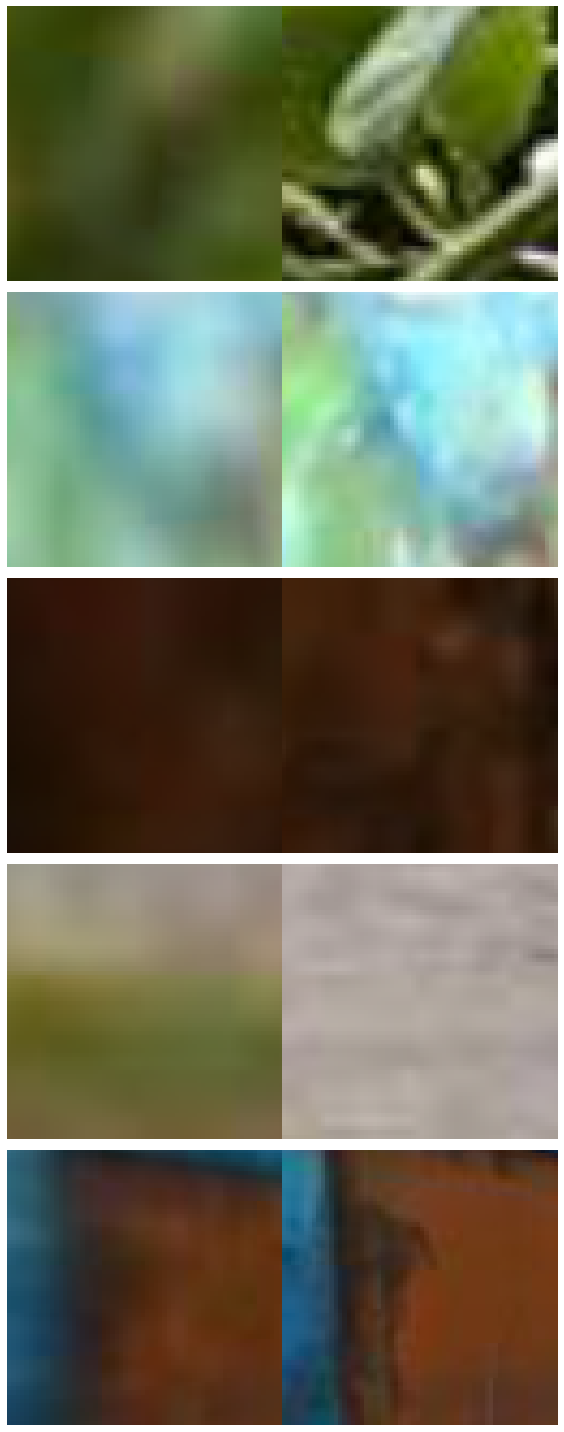

In [13]:
data_gen.show_batch()

In [14]:
learn_gen = gen_learner_wide(data=data_gen,
                             gen_loss=loss_func,
                             arch = model,
                             nf_factor=nf_factor)

In [15]:
wandbCallbacks = False

if wandbCallbacks:
    import wandb
    from wandb.fastai import WandbCallback
    config={"batch_size": bs,
            "img_size": (sz, sz),
            "learning_rate": lr,
            "weight_decay": wd,
            "num_epochs": epochs
    }
    wandb.init(project='SuperRes', config=config, id="gen_mobilenetV3_SSIM"+ datetime.now().strftime('_%m-%d_%H:%M'))

    learn_gen.callback_fns.append(partial(WandbCallback, input_type='images'))

In [16]:
# learn_gen.lr_find()
# learn_gen.recorder.plot()
# learn_gen.summary()

In [17]:
do_fit(learn_gen, epochs, gen_name+"_64px_0", slice(lr))

epoch,train_loss,valid_loss,time


KeyboardInterrupt: 

# 512px 

In [ ]:
bs=4
sz=512
epochs = 5

In [ ]:
data_gen = get_DIV2k_data(path_lowRes_mild, bs, sz)

In [ ]:
learn_gen.data = data_gen
learn_gen.freeze()
gc.collect()

In [ ]:
learn_gen.load(gen_name+"_256px_0")

In [ ]:
learn_gen.lr_find()
learn_gen.recorder.plot()

In [ ]:
print("Upsize to gen_512")

do_fit(learn_gen, 1, gen_name+"_512px_0",slice(1e-5))